In [2]:
# #Installation

# # Clone the ibm/tsfm
# ! git clone https://github.com/IBM/tsfm.git

# # Change directory. Move inside the tsfm repo.
# %cd tsfm

# # Relax requirement for python version < 3.12
# ! sed -i.orig 's/3\.12/3.13/g' pyproject.toml

# # Install the tsfm library
# #! pip install ".[notebooks]"
# #! python3 -m pip install ".[notebooks]"
# ! pip3 install ".[notebooks]"

In [3]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# tsfm library
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
    plot_preds,
)
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback


In [4]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Data loading, cleaning, manipulation, visualization, and saving tasks are performed in another notebook and saved in a github repository.
target_dataset = "spain"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
TTM_MODEL_REVISION = "1024_96_v1"
TTM_INPUT_SEQ_LEN = 1024

## Helper functions

### Load and pre-process data

In [9]:
# Function to get_data
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

# Define data loaders using TSP from the tsfm library
def get_data(
    dataset_name: str,
    context_length,
    forecast_length,
    fewshot_fraction=1.0
):
    print(dataset_name, context_length, forecast_length)

    config_map = {
        "spain": {
            #"dataset_path": "https://raw.githubusercontent.com/matteorinalduzzi/TTM/main/datasets/venice/venice_small.csv",
            "dataset_path": "/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/Data/spain/spain_clean.csv",
            "timestamp_column": "datetime",
            "id_columns": [],
            "target_columns": ["wave_height"],
            "control_columns": [], 
            "split_config": {
                "train": 0.7,
                #"valid": 0.1,
                "test": 0.2,
            },
        },
    }
    if dataset_name not in config_map.keys():
        raise ValueError(
            f"Currently `get_data()` function supports the following datasets: {config_map.keys()}\n \
                         For other datasets, please provide the proper configs to the TimeSeriesPreprocessor (TSP) module."
        )

    dataset_path = config_map[dataset_name]["dataset_path"]
    timestamp_column = config_map[dataset_name]["timestamp_column"]
    id_columns = config_map[dataset_name]["id_columns"]
    target_columns = config_map[dataset_name]["target_columns"]
    split_config = config_map[dataset_name]["split_config"]
    control_columns = config_map[dataset_name]["control_columns"]


    if target_columns == []:
        df_tmp_ = pd.read_csv(dataset_path)
        target_columns = list(df_tmp_.columns)
        target_columns.remove(timestamp_column)

    data = pd.read_csv(
        dataset_path,
        parse_dates=[timestamp_column],
    )

    column_specifiers = {
        "timestamp_column": timestamp_column,
        "id_columns": id_columns,
        "target_columns": target_columns,
        "control_columns": control_columns,
    
    }

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
        data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
    )
    print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

    return train_dataset, valid_dataset, test_dataset

### Zero-shot evaluation method definition


In [10]:
def zeroshot_eval(
    dataset_name, 
    batch_size,
    context_length=TTM_INPUT_SEQ_LEN,
    forecast_length=96,
    prediction_filter_length=None
):
    # Get data
    _, _, dset_test = get_data(dataset_name=dataset_name, 
                               context_length=context_length, 
                               forecast_length=forecast_length, 
                               fewshot_fraction=1.0
                              )
    
    # Load model
    if prediction_filter_length is None:
        zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM", revision=TTM_MODEL_REVISION
        )
    else:
        if prediction_filter_length <= forecast_length:
            zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=prediction_filter_length
            )
        else:
            raise ValueError(f"`prediction_filter_length` should be <= `forecast_length")
    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size
        )
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # plot
    plot_preds(trainer=zeroshot_trainer, dset=dset_test, plot_dir=os.path.join(OUT_DIR, dataset_name), plot_prefix="test_zeroshot", channel=0)

### Few-shot finetune and evaluation method definition

In [11]:
def fewshot_finetune_eval(
        dataset_name, 
        batch_size, 
        learning_rate=0.001,
        context_length=TTM_INPUT_SEQ_LEN,
        forecast_length=96,
        fewshot_percent=5, 
        freeze_backbone=True,
        num_epochs=50,
        save_dir=OUT_DIR,
        prediction_filter_length=None
    ):
    
    out_dir = os.path.join(save_dir, dataset_name)
    
    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)
    
    # Data prep: Get dataset
    dset_train, dset_val, dset_test = get_data(
        dataset_name,
        context_length,
        forecast_length,
        fewshot_fraction=fewshot_percent / 100
    )


    if prediction_filter_length is None:
        finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM", revision=TTM_MODEL_REVISION,
        )
    elif prediction_filter_length <= forecast_length:
        finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=prediction_filter_length
        )
    else:
        raise ValueError(f"`prediction_filter_length` should be <= `forecast_length")
    
    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to=None,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)
    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # plot
    plot_preds(trainer=finetune_forecast_trainer, dset=dset_test, plot_dir=os.path.join(OUT_DIR, dataset_name), plot_prefix="test_fewshot", channel=0)

## Run predictions on the dataset

### Zero-shot


spain 1024 96
Data lengths: train = 5164, val = 803, test = 1700


/var/folders/x7/k4v9jmwn26x9tw0wd3vfqdw00000gn/T/ipykernel_54857/3903190937.py:69: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.80M [00:00<?, ?B/s]

++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


  0%|          | 0/27 [00:00<?, ?it/s]

{'eval_loss': 0.462529718875885, 'eval_runtime': 7.787, 'eval_samples_per_second': 218.314, 'eval_steps_per_second': 3.467}


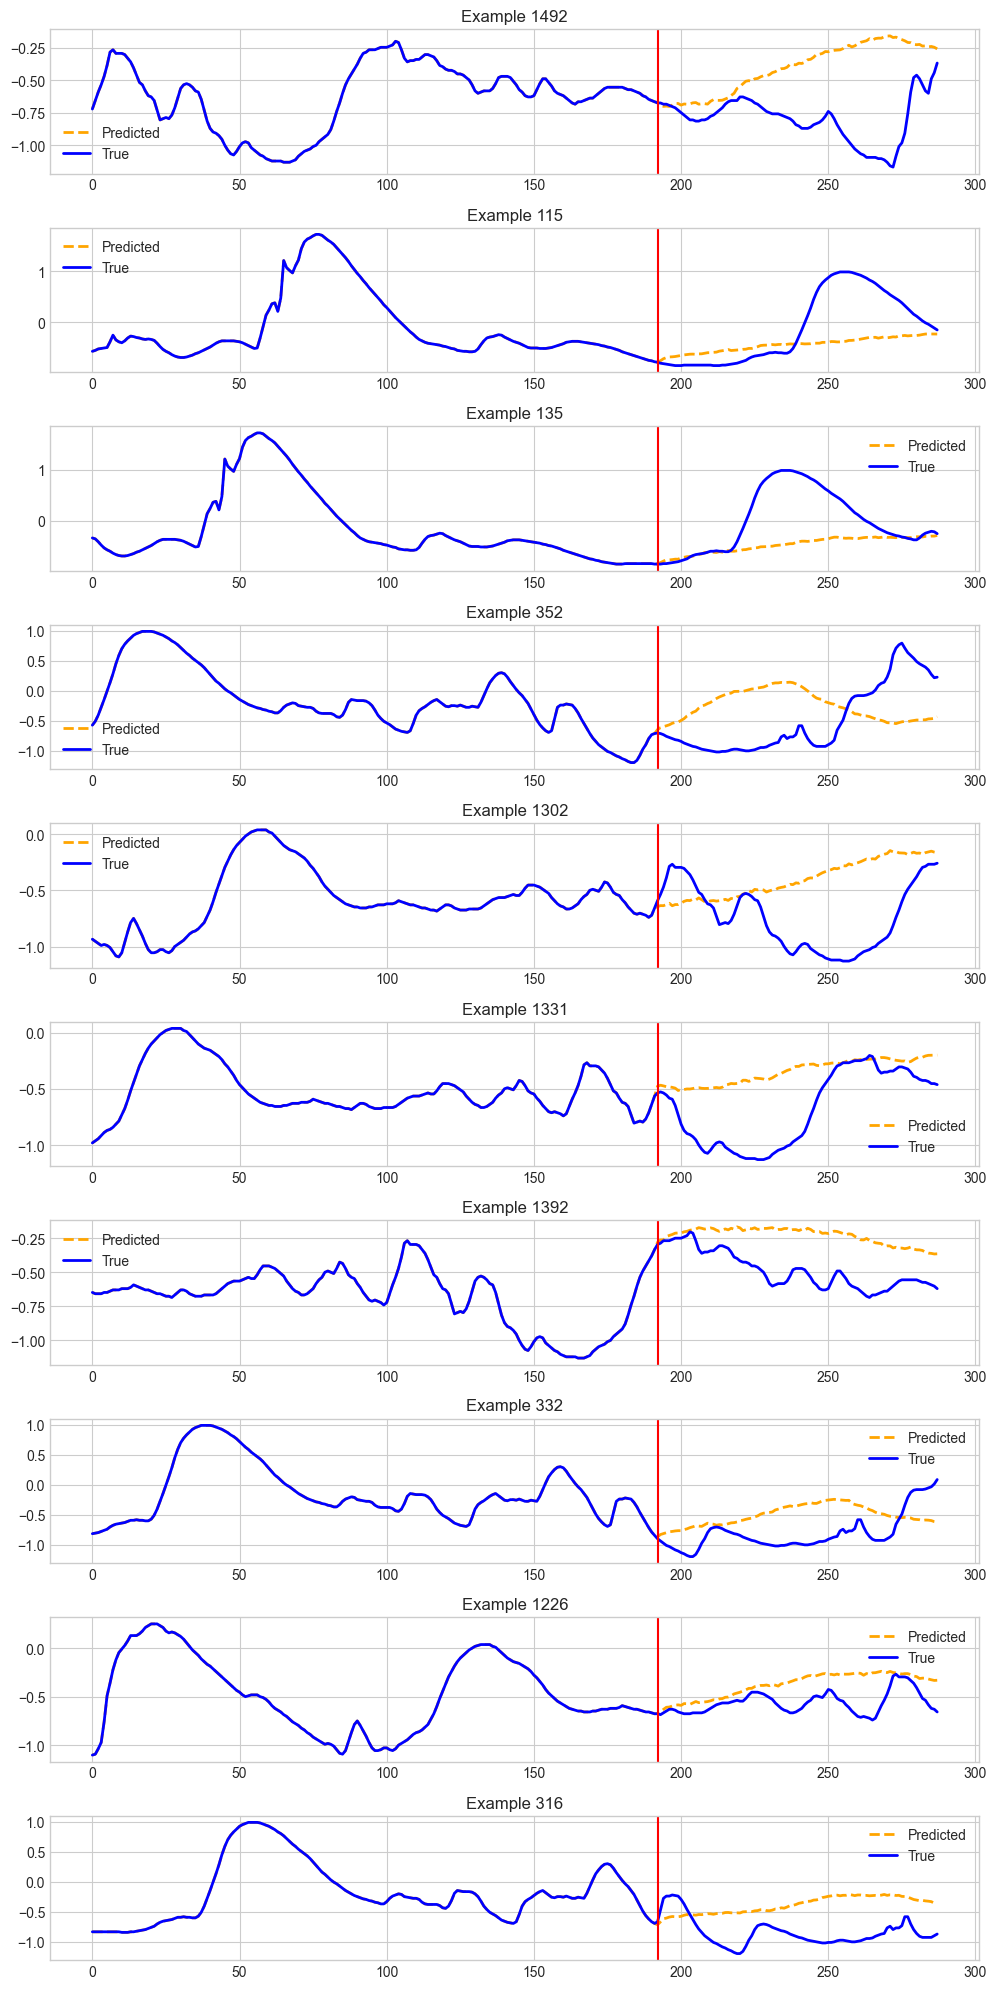

In [12]:
zeroshot_eval(dataset_name=target_dataset, batch_size=64)

### Few shot 5%

In [ ]:
fewshot_finetune_eval(dataset_name=target_dataset, batch_size=64)